# Implémentez un modèle de scoring
## Phase 2.1 : Modélisation des données 

On va modéliser les  données précédemment cleaner pour essayer de sortir le meilleur modèle

In [1]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# system
import gc
gc.enable()

from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score

from imblearn.over_sampling import SMOTE
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval
from lightgbm import LGBMClassifier
import lightgbm as lgb


Using TensorFlow backend.


### Préparation des données pour modélisation 

On a un jeu de train et un jeu de test sans valeur target, on va d'abord s'intéresser juste au jeu de train qu'on va splitter pour voir résultat de notre modélisation par rapport à la valeur target

In [2]:
data = pd.read_feather('../../output/m_train_small.ft')


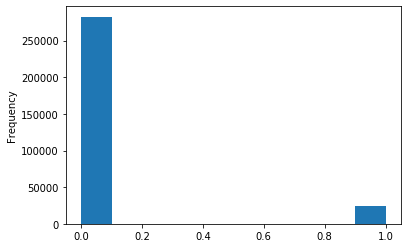

In [3]:
data['TARGET'].astype(int).plot.hist();

Première remarque est que la valeur target est de 0 pour 90% des données, ce qui fait que le jeu de données est très deséquilibré

In [4]:
data.head()

,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,previous_NAME_TYPE_SUITE_Unaccompanied_sum,client_cash_NAME_CONTRACT_STATUS_Signed_mean_max,previous_PRODUCT_COMBINATION_POSindustrywithoutinterest_mean,client_credit_AMT_DRAWINGS_CURRENT_max_sum,previous_WEEKDAY_APPR_PROCESS_START_TUESDAY_sum,previous_CODE_REJECT_REASON_HC_sum,previous_NAME_GOODS_CATEGORY_PhotoCinemaEquipment_mean,OCCUPATION_TYPE_Highskilltechstaff,TARGET,SK_ID_CURR
0,0.083037,0.139376,0.262949,-9461,1.757837e+05,406597.5,24700.5,-637,-103.0,780.0,...,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,0,1,100002
1,0.311267,NaN,0.622246,-16765,1.154108e+06,1293502.5,35698.5,-1188,-606.0,1216.0,...,1.0,0.000000,0.0,NaN,0.0,0.0,0.0,0,0,100003
2,NaN,0.729567,0.555912,-19046,1.607175e+04,135000.0,6750.0,-225,-408.0,-382.0,...,1.0,0.000000,0.0,NaN,0.0,0.0,0.0,0,0,100004
3,NaN,NaN,0.650442,-19005,9.944767e+05,312682.5,29686.5,-3039,NaN,NaN,...,3.0,0.000000,0.0,0.0,1.0,0.0,0.0,0,0,100006
4,NaN,NaN,0.322738,-19932,4.837564e+05,513000.0,21865.5,-3038,-1149.0,-783.0,...,2.0,0.076923,0.0,NaN,0.0,0.0,0.0,0,0,100007


On splitte notre jeu de données en train / test pour la modélisation 

In [5]:
labels= data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['TARGET', 'SK_ID_CURR']), 
                                                    labels, 
                                                    stratify=labels, 
                                                    test_size=0.25)


On va juste faire quelque transformations de base sur les données à savoir, remplacer les valeur infinies par nan, utiliser la médiane pour les valeurs manquantes, et finalement scaler les données en utilisant un  MinMaxScaler


In [6]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0.01-1
scaler = MinMaxScaler(feature_range = (0.01, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(imputer.transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

# Repeat with the scaler
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

print('Training data shape: ', X_train_scaled.shape)
print('Testing data shape: ', X_test_scaled.shape)

Training data shape:  (230633, 338)
Testing data shape:  (76878, 338)


### Utilisation d'une baseline 

On commence par utiliser une simple regression logistique comme baseline

In [7]:

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.0001)

In [8]:
log_reg.score(X_test_scaled, y_test)

0.9192746949712531

A priori le modèle est pas mal, il donne 91% d'accuracy, on va regarder le résultat sur le jeu de train, avec une matrice de confusion

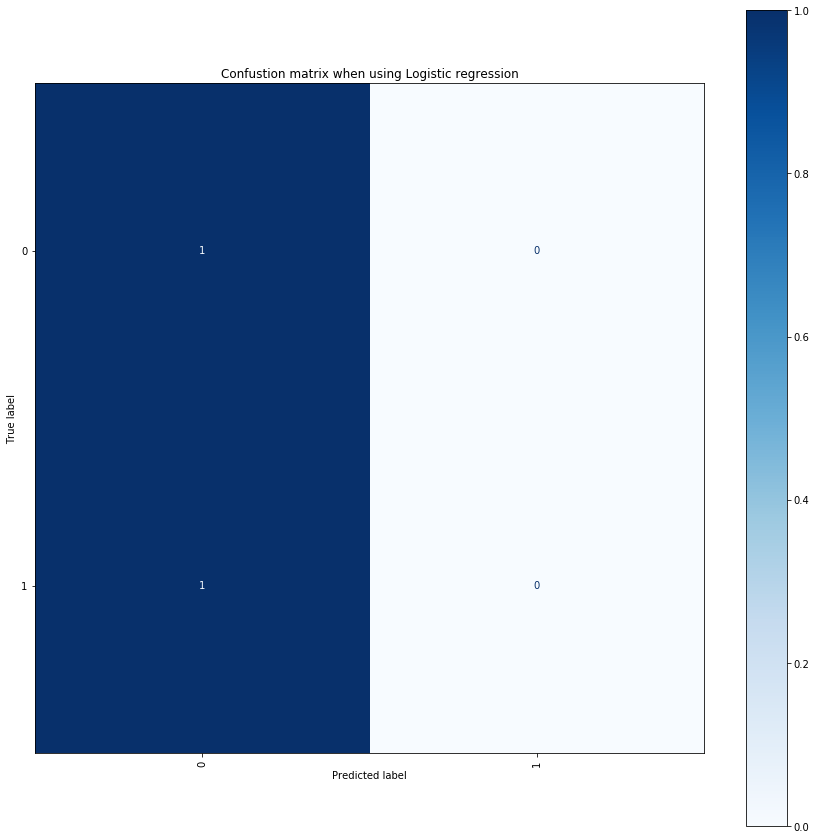

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(log_reg, 
                             X_test_scaled, y_test, cmap=plt.cm.Blues,
                             normalize='true', 
                             xticks_rotation='vertical',
                             ax=ax)
disp.ax_.set_title('Confustion matrix when using Logistic regression')
plt.show()

Le modèle renvoie toujours 1, ce qui explique l'accuracy elevée, pour une deuxième baseline on va enrichir nos données en faisant de l'over sampling en utilisant SMOTE

In [10]:
sm = SMOTE(random_state=42, n_jobs=4)
sampled_train, sampled_labels = sm.fit_resample(X_train_scaled, y_train)

Regardons maintenant la répartition des labels

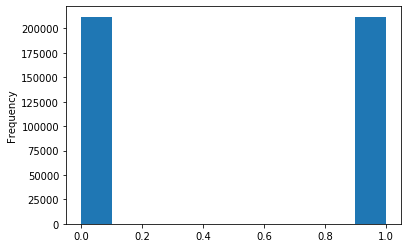

In [11]:
sampled_labels.astype(int).plot.hist()

Les données sont beaucoup mieux réparties maintenant, on va lancer la meme regression logistique pour voirle résultat

In [12]:
# Make the model with the specified regularization parameter
log_reg_sampled = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_sampled.fit(sampled_train, sampled_labels)

LogisticRegression(C=0.0001)

In [13]:
log_reg_sampled.score(X_test_scaled, y_test)

0.675524857566534

On remarque que le score est bien plus bas qu'avant, regardons la matrice de confusion

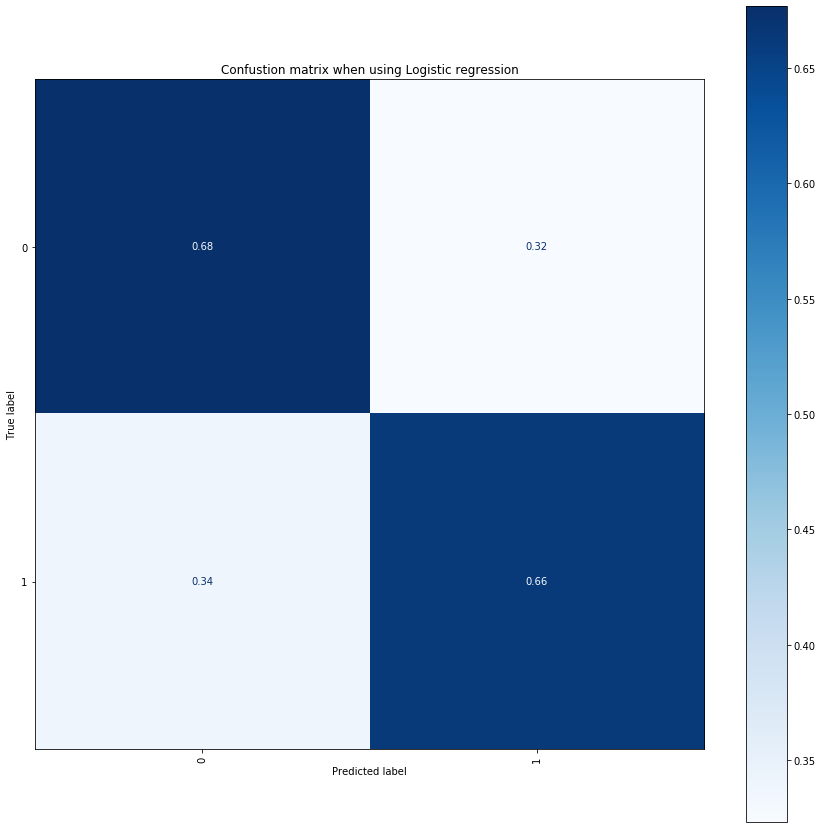

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(log_reg_sampled, 
                             X_test_scaled, y_test, cmap=plt.cm.Blues,
                             normalize='true', 
                             xticks_rotation='vertical',
                             ax=ax)
disp.ax_.set_title('Confustion matrix when using Logistic regression')
plt.show()

Le score est certes plus bas, mais on prédit avec la même accuracy les données minoritaires, comme majoritaires

In [15]:
roc_auc_score(y_test, log_reg.predict(X_test_scaled))

0.5

In [16]:
roc_auc_score(y_test, log_reg_sampled.predict(X_test_scaled))

0.6694759109564888

En regardant le AUC score on remarque en effet que le score est bien mieux maintenant

### Optimisation du modèle

On va utiliser hyperopt pour chercher les paramètres optimaux pour un Light GBM classifier on a voulu tester beaucoup de modèle, mais malheureusement la puissance de mon ordinateur actuel ne le permet pas 

In [17]:
models_spaces = {}
models_spaces['lgbm'] = { 
    'model':             LGBMClassifier,
    'num_leaves':        hp.choice('lgbm_num_leaves', range(6,50)),
    'min_child_samples': hp.choice('lgbm_min_child_samples', range(20,100)),
    'min_child_weight':  hp.uniform('lgbm_min_child_weight', 0.00001, 20),
    'colsample_bytree':  hp.uniform('lgbm_colsample_bytree', 0.2, 1),
    'reg_alpha':         hp.uniform('lgbm_reg_alpha', 0, 1),
    'reg_lambda':        hp.uniform('lgbm_reg_lambda', 0, 1),
    'n_estimators':      10000,
    'objective':         'binary',
    'boosting_type':     'goss',
    'class_weight':      'balanced'
}

In [18]:
space = {}
space['models_spaces'] = hp.choice(
        'models_spaces',
        [ models_spaces[key] for key in models_spaces ]
    )


#### Définition d'une fonction de cout 

Actuellement, le score AUC représenterait le mieux notre fonction de cout, ou même un F1 score, 
Ce qu'on voudrait c'est être plus proche de la réalité, on va estimer que la banque dégage une marge par crédit de 0.5%, la banque pert cette marge là si elle n'accord pas un crédit à un client qui va payer, et par contre elle perd potentiellement tout l'argent du crédit si le client est mauvais payeur, et ça sera notre fonction de cout, voyons ce que ça donne pour certaines données

In [19]:
r = 0.005
cost = X_train[['AMT_CREDIT', 'AMT_ANNUITY']]
duration_years = X_train['AMT_CREDIT'] / X_train['AMT_ANNUITY']
annuity_factor = (1 - (1+r)**(-1 * duration_years)) / r
installments = X_train['AMT_CREDIT'] / annuity_factor
credit_cost = installments * duration_years  - X_train['AMT_CREDIT']
cost['cost'] = credit_cost
cost['percent of credit'] = 100 * credit_cost / X_train['AMT_CREDIT']

cost

,AMT_CREDIT,AMT_ANNUITY,cost,percent of credit
0,1084500.0,35973.0,86494.314855,7.975502
1,1886850.0,52015.5,180982.657700,9.591788
2,50940.0,5877.0,1239.027085,2.432326
3,1288350.0,37800.0,116105.092402,9.011922
4,634500.0,24714.0,43178.740734,6.805160
...,...,...,...,...
230628,188685.0,10008.0,9504.069990,5.037003
230629,1762110.0,48456.0,169440.079598,9.615749
230630,734994.0,23841.0,59934.899213,8.154475
230631,1575000.0,41679.0,157398.851109,9.993578


que le cout du crédit varie suivant le montant accordé entre, ça reste dans les  alentours de 3 à 8 %

In [20]:
r = 0.005
def credit_gain(X, y_pred, y_true):
    '''
        Fonction pour définir le cout on fonction de la prédiction et de la vraie valeur
        Elle renvoie la moyenne de la perte/ gain de la banque
    '''
    duration_years = X['AMT_CREDIT'] / X['AMT_ANNUITY']
    annuity_factor = (1 - (1+r)**(-1 * duration_years)) / r
    installments = X['AMT_CREDIT'] / annuity_factor
    credit_cost = installments * duration_years  - X['AMT_CREDIT']
    total_gain = 0
    for i,j,k,l in zip(y_pred, y_true, credit_cost, X['AMT_CREDIT']):
        if i == j:
            if i == 1:
                total_gain += 0
            if i == 0:
                total_gain += k
        else:
            if i == 1:
                total_gain -= k
            if i == 0:
                total_gain -= l
    return total_gain / len(y_pred)

def credit_gain_on_proba(X, y_proba, y_true, threshold=0.5):
    '''
       A partir de quel proba decide t on quele client est mauvais payeur ? 
    '''
    mask = y_proba > threshold
    y_pred = mask.astype(int)
    return credit_gain(X, y_pred, y_true)
    
def expected_gain(model, X, y_true):
    '''
        Gain sans utiliser la proba, mais on utilisant directement la prédiction du modèle
    '''
    y_pred = model.predict(X)
    score = credit_gain(X, y_pred, y_true)
    return score

def credit_gain_on_optimal_proba(X, y_proba, y_true):
    '''
        Utilisation d'une proba optimale en fonction du modèle pour maximiser les gains
    '''
    scores=[]
    for threshold in np.linspace(0, 1, num=11):
        mask = y_proba > threshold
        y_pred = mask.astype(int)
        score = credit_gain(X, y_pred, y_true)
        scores.append(score)
    return max(scores)
    


Maintenant qu'on a défini nos gonctions voyons ce que ça donne pour nos deux baselines

In [21]:
credit_gain_on_optimal_proba(X_test, log_reg.predict_proba(X_test_scaled)[:, 1], y_test)

-192.17115580703856

In [22]:
credit_gain_on_optimal_proba(X_test, log_reg_sampled.predict_proba(X_test_scaled)[:, 1], y_test)

709.1562391050633

On voit qu'en moyenne, les cout se sont améliorés avec le sampling, essayons maintenant avec un modèle amélioré

Pour des raisons de performance, on préfère faire le scaling, et le sampling en amont, (l'ordinateur a planté pas mal de fois à cause de l'utilisation de la pipeline) 
Bien évidemment sur le cloud, ou avec une meilleur machine, l'utilisation du pipeline est recommandée

In [23]:
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)

On définit notre fonction d'objectif, on définit un early stopping qui  prendra en compte les deux score : AUC et notre score défini ci dessus

In [24]:
def objective(params):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    parameters = params['models_spaces'].copy()
    del parameters['model']
    clf = params['models_spaces']['model'](**parameters)
    print(parameters)

    train_set = lgb.Dataset(X_train_scaled, label=y_train)
    
    eval_func = lambda y, X : ('credit_score', credit_gain_on_proba(X_train.iloc[X.get_label()], y, X.get_label()), True)
        
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC and on credit cost function
    cv_results = lgb.cv(parameters, train_set, nfold=5,verbose_eval=10, num_boost_round=1000,
                        early_stopping_rounds=100, metrics='auc', feval=eval_func,seed = 42)
  
    # Extract the best score
    best_score = max(cv_results['credit_score-mean'])
    
    # Loss must be minimized
    loss = -1 * best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

Finalement on lance hyperopt, on défini un "early stopping" sur les trials, de telle façon que si le score ne s'améliore pas pendant 10 trias, on renvoie le modèle

In [25]:
def run_trials():
    max_trials = 100  # max trials if the early stopping isn't reached
    count = 0  # number of steps with no loss improvement
    max_count = 10  # early stopping rounds
    threshold = 1e-4  # loss impovement threshold
    previous_loss = None
    trials = None
    max_evals = 0
    best_params = None
    while max_evals <= max_trials:
        if trials is None:
            trials = Trials()
            max_evals = 1
        else:
            max_evals = len(trials.trials) + 1
        best_params = fmin(
            objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials)
        best_params = space_eval(space, best_params)
        loss = trials.best_trial['result']['loss']

        if previous_loss is not None:
            if abs(previous_loss - loss) < threshold:
                count = count + 1
            else:
                count = 0

        print('----------------------------------')
        print('Current step is {}'.format(max_evals))
        print('best model params are {}'.format(best_params['models_spaces']))
        print('Current loss is {}'.format(trials.best_trial['result']['loss']))
        if previous_loss is not None:
            print('Loss improvement is {}'.format(previous_loss - loss))

        previous_loss = loss
        if count >= max_count:
            print('Early stopping for reaching max iteration without any improvement on loss')
            break

    return best_params, trials

le modèle prends 12h à tourner sur ma machine, ce qui peut être compliqué quand on veut faire des essais, j'ai décidé de le sauver dans un fichier et de repartir de ce fichier s'il existe

In [26]:
if os.path.isfile('../../output/best_estimator.pkl'):
    print('Found an already saved classifier, using it!')
    classifier = pickle.load(open('../../output/best_estimator.pkl', 'rb'))
else:
    best_params, trials = run_trials()
    model = best_params['models_spaces'].pop('model')
    classifier = model(**best_params['models_spaces'])
    eval_func = lambda y, X : ('credit_score', credit_gain_on_proba(X_test, y, y_test), True)
    classifier.fit(X_train_scaled, y_train, eval_metric=eval_func, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds=200, verbose=5)
    pickle.dump(classifier, open('../../output/best_estimator.pkl', 'wb'))

Found an already saved classifier, using it!


In [27]:
classifier

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=0.7069849102479817, min_child_samples=87,
               min_child_weight=4.2031367501272445, n_estimators=10000,
               num_leaves=25, objective='binary', reg_alpha=0.7724008005312301,
               reg_lambda=0.720234086958816)

In [28]:
credit_gain_on_optimal_proba(X_test, classifier.predict_proba(X_test_scaled)[:,1], y_test)

7027.510123697315

Le gain potentiel a l'air bien mieux qu'avant, on regarde graphiquement ce que ça donne

In [29]:
results_df = pd.DataFrame(columns=['Metric', 'Model', 'Score'])

y_test_probas = classifier.predict_proba(X_test_scaled)[:,1]
y_pred = classifier.predict(X_test_scaled)
# on renseigne les résultats pour le meilleur estimateur
results_df.loc[0] = ['AUC', 'Light GBM (preprocessed)', roc_auc_score(y_test, y_test_probas)]
results_df.loc[1] = ['Accuracy', 'Light GBM (preprocessed)', accuracy_score(y_test, y_pred)]
results_df.loc[2] = ['Credit Score', 'Light GBM (preprocessed)', credit_gain_on_optimal_proba(X_test, y_test_probas, y_test)]


y_test_probas = log_reg.predict_proba(X_test_scaled)[:,1]
y_pred = log_reg.predict(X_test_scaled)
# puis pour la baseline
results_df.loc[3] = ['AUC', 'Logistic regression', roc_auc_score(y_test, y_test_probas)]
results_df.loc[4] = ['Accuracy', 'Logistic regression', accuracy_score(y_test, y_pred)]
results_df.loc[5] = ['Credit Score', 'Logistic regression', credit_gain_on_optimal_proba(X_test, y_test_probas, y_test)]

y_test_probas = log_reg_sampled.predict_proba(X_test_scaled)[:,1]
y_pred = log_reg_sampled.predict(X_test_scaled)
# et enfin baseline + SMOTE
results_df.loc[6] = ['AUC', 'Logistic regression + SMOTE', roc_auc_score(y_test, y_test_probas)]
results_df.loc[7] = ['Accuracy', 'Logistic regression + SMOTE', accuracy_score(y_test, y_pred)]
results_df.loc[8] = ['Credit Score', 'Logistic regression + SMOTE', credit_gain_on_optimal_proba(X_test, y_test_probas, y_test)]



In [30]:
results_df.head(10)

,Metric,Model,Score
0,AUC,Light GBM (preprocessed),0.803347
1,Accuracy,Light GBM (preprocessed),0.751714
2,Credit Score,Light GBM (preprocessed),7027.510124
3,AUC,Logistic regression,0.714433
4,Accuracy,Logistic regression,0.919275
5,Credit Score,Logistic regression,-192.171156
6,AUC,Logistic regression + SMOTE,0.730365
7,Accuracy,Logistic regression + SMOTE,0.675525
8,Credit Score,Logistic regression + SMOTE,709.156239


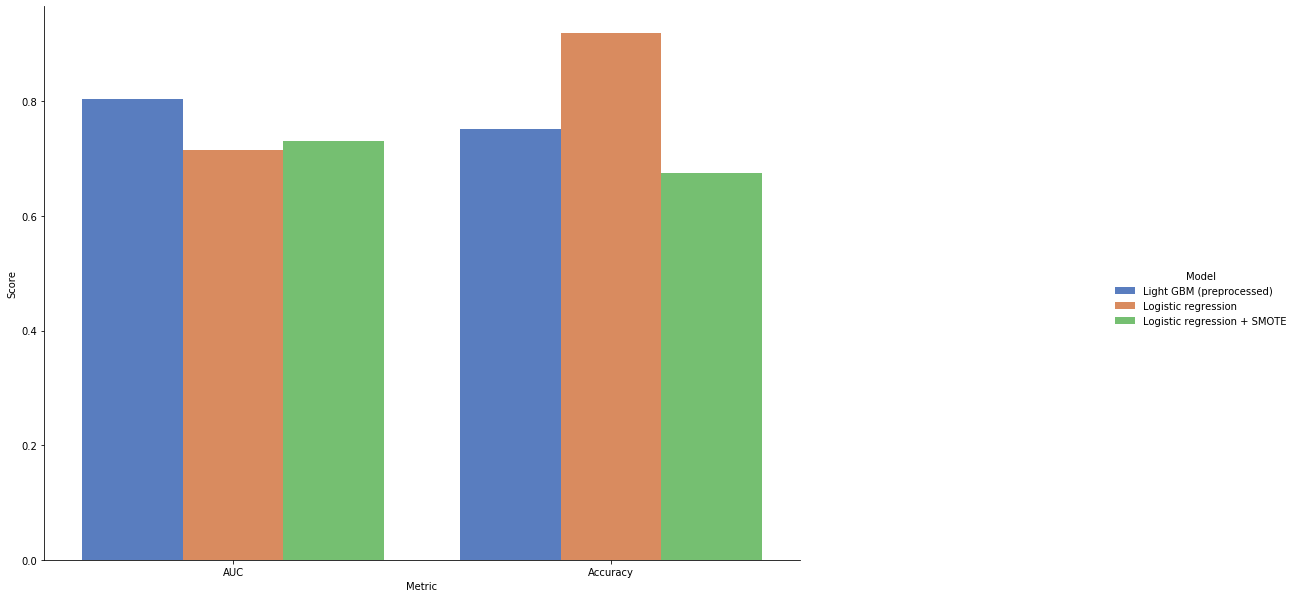

In [33]:
g = sns.catplot(x='Metric', y='Score', hue='Model', data=results_df[results_df['Metric'] != 'Credit Score'],
                kind='bar', palette='muted')
g.fig.set_figwidth(20)
g.fig.set_figheight(9)

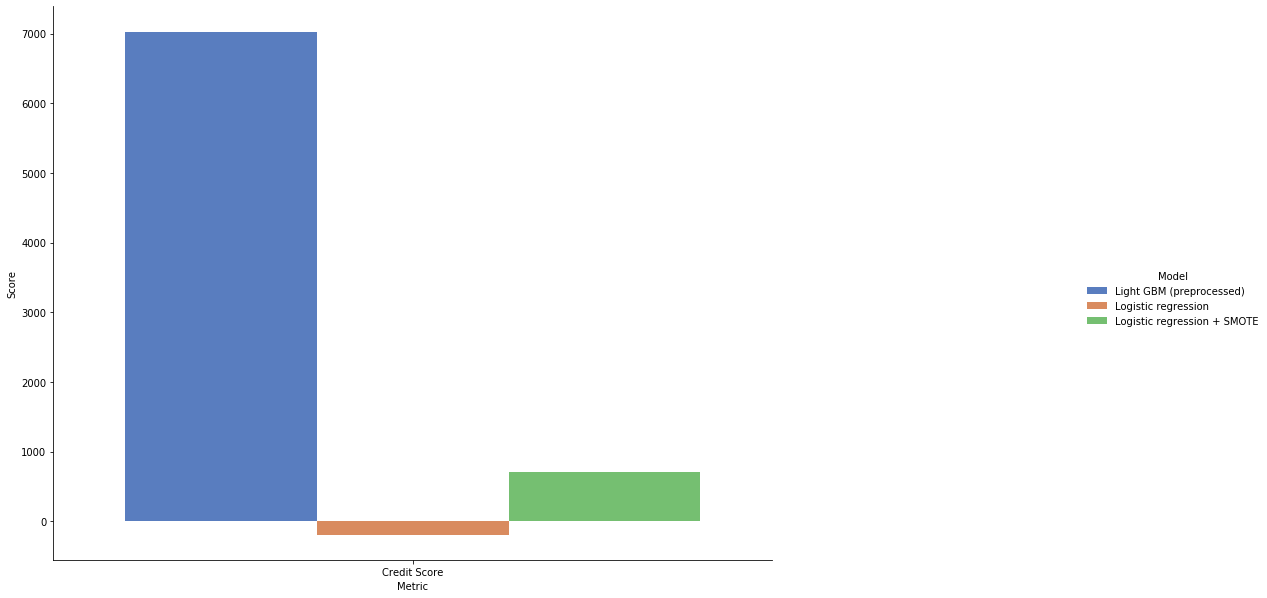

In [34]:
g = sns.catplot(x='Metric', y='Score', hue='Model', data=results_df[results_df['Metric'] == 'Credit Score'],
                kind='bar', palette='muted')
g.fig.set_figwidth(20)
g.fig.set_figheight(9)

Finalement on sauve toutes les données modélisée, pour  pouvoir faire le dashboard après, donc on applique l'imputer, et le scaling sur toute la dataframe

In [35]:
target_col = data['TARGET']
key_col = data['SK_ID_CURR']

data_to_save = data.drop(columns=['TARGET', 'SK_ID_CURR'])
data_to_save.replace([np.inf, -np.inf], np.nan, inplace=True)

data_to_save = pd.DataFrame(imputer.transform(data_to_save),columns = data_to_save.columns)
data_to_save = pd.DataFrame(scaler.transform(data_to_save),columns = data_to_save.columns)
# save data
data_to_save['TARGET'] = target_col
data_to_save['SK_ID_CURR'] = key_col
data_to_save.to_feather('../../output/data_after_modelisation.ft')
